In [1]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.regularizers import l1
from sklearn.preprocessing import MinMaxScaler

In [2]:
# Load Data
data = pd.read_csv("christchurch_data.csv")

In [3]:
data['Date'] = pd.to_datetime(data['Date'], format='%Y/%m/%d')
data['Date'] = data['Date'].apply(lambda x: x.value) # Total Nanoseconds from 1970-01-01 00:00:00 UTC to That Datetime 

In [4]:
# Data Preprocessing
for col in data.columns:
    # Consider Only Non-dash Values for Median Calculation
    median = pd.to_numeric(data[col], errors='coerce').median()
    # Replace Dashes with Median
    data[col] = pd.to_numeric(data[col], errors='coerce').fillna(median)

data = data.fillna(data.median())

# Identify Features and Target Variable
features = data.drop(columns=['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)'])
target = data[['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)']]

# Normalization
# Create a MinMaxScaler Instance for Input Features
input_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_features = input_scaler.fit_transform(features)

# Create Another MinMaxScaler Instance for the Target Variable 
output_scaler = MinMaxScaler(feature_range=(0, 1))
scaled_target = output_scaler.fit_transform(target)

# Save Both Scaler Instances Separately
import joblib
joblib.dump(input_scaler, 'Christchurch_input_scaler.pkl')
joblib.dump(output_scaler, 'Christchurch_output_scaler.pkl')

# Split Data
X_train, X_test, y_train, y_test = train_test_split(scaled_features, scaled_target, test_size=0.2, random_state=42, shuffle=True)
# Adjust Data Shape for CNN and LSTM
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [5]:
data.describe()

,Date,Daily Average PM2.5 (ug/m3),Daily Average PM10 (ug/m3),WDir(Deg),WSpd(m/s),Rain(mm),RH(%),Tmax(C),Tmin(C),lightCount,heavyCount
count,1.461000e+03,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,1.640909e+18,6.158693,16.330335,150.931554,2.159138,1.636345,78.601643,18.060643,8.142847,5308.513591,444.770669
std,3.645205e+16,4.723269,8.365617,103.731493,1.244448,5.653771,16.487940,5.313438,4.943946,1054.093259,159.042296
min,1.577837e+18,0.058333,1.283333,0.000000,0.000000,0.000000,29.000000,5.700000,-4.600000,536.547619,71.075130
25%,1.609373e+18,3.391667,10.837500,52.000000,1.200000,0.000000,69.000000,14.000000,4.400000,4830.400350,272.868821
50%,1.640909e+18,4.829167,14.966667,166.000000,1.900000,0.000000,82.000000,17.900000,8.600000,5518.514056,511.155556
75%,1.672445e+18,7.116667,20.054167,231.000000,3.000000,0.400000,93.000000,21.200000,12.100000,5988.154812,576.107724
max,1.703981e+18,45.437500,74.858333,360.000000,7.800000,69.400000,100.000000,36.600000,21.800000,7629.865497,685.019737


In [6]:
# Calculate the Number of Features
n_features = features.shape[1]
feature_names = features.columns

# Build LSTM Model
model = Sequential([
    LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2]), activation='relu'),
    Dropout(0.2),
   LSTM(200, return_sequences=False, activation='relu'),
  Dropout(0.2),
    Dense(2)
])
# Compile the Model
from tensorflow.keras.optimizers import Adam
optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='mean_squared_error')

# Set Early Stopping to Avoid Overfitting
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the Model
history = model.fit(
    X_train, y_train, 
    epochs=100, 
    batch_size=128, 
    verbose=2, 
#    shuffle=False, 
    validation_split=0.1, 
    callbacks=[early_stopping]
)

Epoch 1/100
9/9 - 1s - loss: 0.0246 - val_loss: 0.0180 - 1s/epoch - 150ms/step
Epoch 2/100
9/9 - 0s - loss: 0.0143 - val_loss: 0.0167 - 191ms/epoch - 21ms/step
Epoch 3/100
9/9 - 0s - loss: 0.0133 - val_loss: 0.0153 - 233ms/epoch - 26ms/step
Epoch 4/100
9/9 - 0s - loss: 0.0127 - val_loss: 0.0150 - 234ms/epoch - 26ms/step
Epoch 5/100
9/9 - 0s - loss: 0.0125 - val_loss: 0.0149 - 237ms/epoch - 26ms/step
Epoch 6/100
9/9 - 0s - loss: 0.0122 - val_loss: 0.0146 - 235ms/epoch - 26ms/step
Epoch 7/100
9/9 - 0s - loss: 0.0121 - val_loss: 0.0142 - 235ms/epoch - 26ms/step
Epoch 8/100
9/9 - 0s - loss: 0.0118 - val_loss: 0.0139 - 237ms/epoch - 26ms/step
Epoch 9/100
9/9 - 0s - loss: 0.0115 - val_loss: 0.0135 - 236ms/epoch - 26ms/step
Epoch 10/100
9/9 - 0s - loss: 0.0114 - val_loss: 0.0133 - 236ms/epoch - 26ms/step
Epoch 11/100
9/9 - 0s - loss: 0.0114 - val_loss: 0.0135 - 245ms/epoch - 27ms/step
Epoch 12/100
9/9 - 0s - loss: 0.0116 - val_loss: 0.0128 - 252ms/epoch - 28ms/step
Epoch 13/100
9/9 - 0s - los

In [7]:
test_loss = model.evaluate(X_test, y_test, verbose=0)
print(f'Test Loss: {test_loss}')

Test Loss: 0.008400311693549156


In [8]:
# Prediction
predictions = model.predict(X_test)

# Use the MinMaxScaler Instance of Output Data to Inverse Scale Predictions 
predictions_inversed = output_scaler.inverse_transform(predictions)

# Use the MinMaxScaler Instance of Output Data to Inverse Scale True Test Data
y_test_inversed = output_scaler.inverse_transform(y_test)

# Calculate Evaluation Metrics
mse = mean_squared_error(y_test_inversed, predictions_inversed)
mae = mean_absolute_error(y_test_inversed, predictions_inversed)
r2 = r2_score(y_test_inversed, predictions_inversed)

# Print Evaluation Metrics
print("Mean Squared Error (MSE): ", mse)
print("Mean Absolute Error (MAE): ", mae)
print("R² Score: ", r2)

10/10 [==============================] - 0s 3ms/step
Mean Squared Error (MSE):  34.17945206214422
Mean Absolute Error (MAE):  3.9903637838122
R² Score:  0.1855204028050909


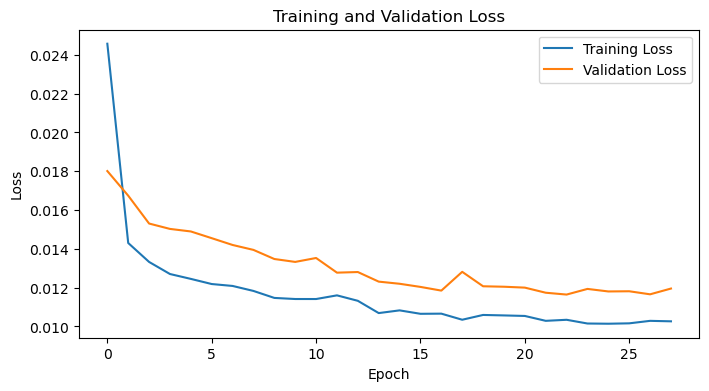

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


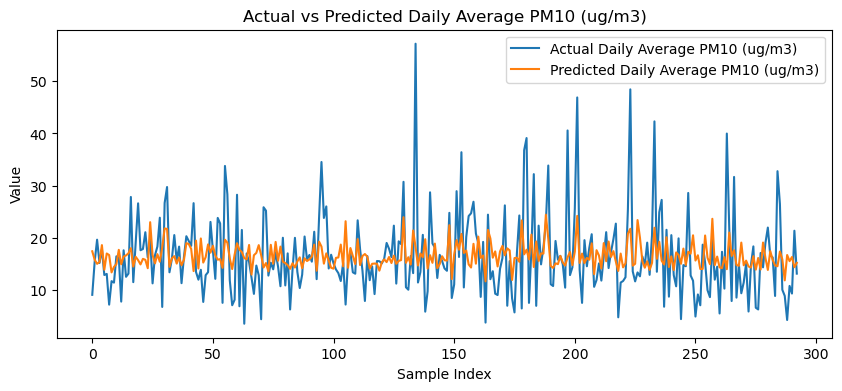

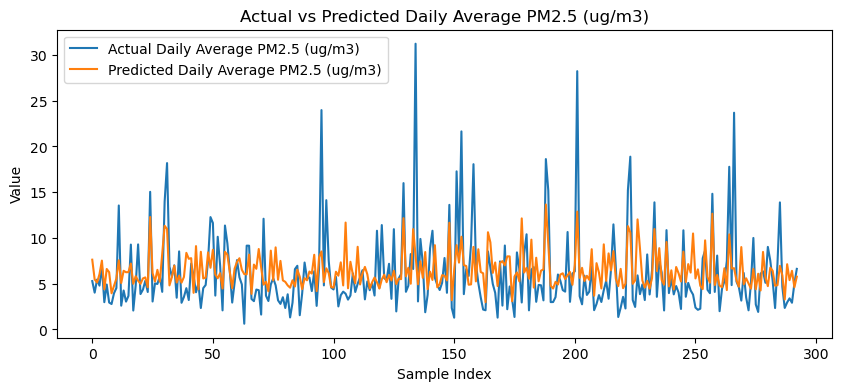

In [10]:
# Plot Predictions vs. Actual Values
target_labels = ['Daily Average PM10 (ug/m3)', 'Daily Average PM2.5 (ug/m3)']
for i in range(2):
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inversed[:, i], label=f'Actual {target_labels[i]}')
    plt.plot(predictions_inversed[:, i], label=f'Predicted {target_labels[i]}')
    plt.title(f'Actual vs Predicted {target_labels[i]}')
    plt.ylabel('Value')
    plt.xlabel('Sample Index')
    plt.legend()
    plt.show()


In [11]:
# Save the Entire Model to an HDF5 File
model.save('/Users/yangyi/christchurch_model1.h5')

/Users/yangyi/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
